In [2]:
import logging
import argparse
from sys import argv, exit, path
from os import system
from os.path import exists, dirname
import datetime
import findspark  # find spark home directory
findspark.init('/usr/hdp/current/spark2-client')
from pyspark.sql import HiveContext
from pyspark.sql.functions import pandas_udf, PandasUDFType

import pandas as pd

path.insert(0, "/home/prod/git/common/config_utils")
from load_user_config import load_config_from_file, convert_namedtuple_to_dict
path.insert(0, "/home/prod/git/common/logging")
from user_logging import assign_log_handler, close_log_handler
path.insert(0, "/home/prod/git/common/pyspark_utils")
from get_spark import get_spark
path.insert(0, "/home/prod/git/common/collect_raw_data_utils")
from get_guobiao_raw_data_missing_days import get_guobiao_raw_data_missing_days
from data_collection import get_raw_records_in_spark
from aggregate_raw_data import aggregate_raw_data
import pyspark.sql.functions as F

In [2]:
SPARK_CONFIG_LIST = [
    ('spark.app.name', 'current'),     # spark job name
    ('spark.yarn.queue', 'prod'),                          # for production code, use 'prod', else use 'dev'
    ('spark.master', 'yarn'),                              # choose between 'yarn', 'local', or 'local[*]'
    ('spark.submit.deployMode', 'client'),                 # 'client' or 'cluster' mode
    ('spark.yarn.am.memory', '12g'),                       # memory for spark driver (application master), for client mode
    ('spark.executor.memory', '6g'),                       # memory for each executor
    ('spark.executor.cores', '5'),                         # max number of cores each executor can use (means number of tasks)
    ('spark.executor.instances', '10'),                     # max number of executor instances
    #("spark.sql.execution.arrow.enabled", "true"),         # enable Arrow-based columnar data transfers
    ('spark.sql.hive.convertMetastoreOrc', 'true'),

    # To modify the maximimum size of the Arrow records batches to avoid out of memory exception
    # (data partitions in Spark are converted into Arrow record batches)
    ("spark.sql.execution.arrow.maxRecordsPerBatch", 5000),  # default is 10000
    ('spark.sql.shuffle.partitions', "1000"),
]

In [3]:
spark = get_spark(SPARK_CONFIG_LIST)

In [5]:
spark_context = spark.sparkContext

In [6]:
hive_context = HiveContext(spark_context)

In [8]:
sql_query = "select veh_curr, count(*) as cnt, vintype from \
            (select veh_curr, vin, vintype from {} \
            where veh_charge_st=1 and veh_curr < 0 \
            sort by veh_curr) t \
            group by veh_curr, vintype \
            order by vintype, veh_curr".format('a26_tsp_tbls.a26_gb_orc')
print(sql_query)
spark_df = hive_context.sql("""{}""".format(sql_query))

select veh_curr, count(*) as cnt, vintype from             (select veh_curr, vin, vintype from a26_tsp_tbls.a26_gb_orc             where veh_charge_st=1 and veh_curr < 0             sort by veh_curr) t             group by veh_curr, vintype             order by vintype, veh_curr


In [9]:
def convert_sdf_to_pdf(sdf, n_partitions=None):

    def _map_to_pandas(rdds):
        return [list(rdds)]

    """
    Returns the contents of `sdf` as a pandas.DataFrame using toLocalIterator
    The DataFrame is
    repartitioned if `n_partitions` is passed.
    :param df:              pyspark.sql.DataFrame
    :param n_partitions:    int or None
    :return:                pandas.DataFrame
    """
    if n_partitions is not None and n_partitions > 0:
        sdf = sdf.repartition(n_partitions)
    pdf = sdf.rdd.mapPartitions(_map_to_pandas).toLocalIterator()
    pdf = [pd.DataFrame(data) for data in pdf]
    pdf = pd.concat(pdf)
    pdf.columns = sdf.columns
    return pdf

In [10]:
pdf = convert_sdf_to_pdf(spark_df)

In [11]:
pdf.head()

,veh_curr,cnt,vintype
0,-47.7,1,None
1,-14.8,1,None
2,-1000.0,118,A12
3,-268.9,2,A12
4,-264.4,1,A12


In [37]:
pdf = pd.read_csv("current_frequency.csv")

In [56]:
#a26_pdf = pdf.loc[(pdf.vintype=='A26')&(pdf.cnt > 50),:]
a26_pdf = pdf.loc[pdf.vintype=='A26',:]
a26_pdf.sort_values(by='veh_curr')  #, ascending=False)

,Unnamed: 0,veh_curr,cnt,vintype
3583,3,-1000.0,1,A26
3584,4,-986.9,1,A26
3585,5,-959.4,1,A26
3586,6,-890.7,1,A26
3587,7,-790.3,1,A26
3588,8,-765.0,1,A26
3589,9,-717.9,2,A26
3590,10,-717.1,1,A26
3591,11,-707.0,1,A26
3592,0,-676.1,1,A26


In [4]:
a26_pdf = pd.read_csv("a26_current_freq.csv")

In [38]:
a12_pdf = pdf.loc[pdf.vintype=='A12',:]
a18_pdf = pdf.loc[pdf.vintype=='A18',:]
a26_t_pdf = pdf.loc[pdf.vintype=='A26-T',:]

In [41]:
a12_pdf.to_csv("a12_current_freq.csv")
a26_t_pdf.to_csv("a26_t_current_freq.csv")
a18_pdf.to_csv("a18_current_freq.csv")

[Text(0,0,'-1000.0'),
 Text(0,0,'-950.0'),
 Text(0,0,'-900.0'),
 Text(0,0,'-850.0'),
 Text(0,0,'-800.0'),
 Text(0,0,'-750.0'),
 Text(0,0,'-700.0'),
 Text(0,0,'-650.0'),
 Text(0,0,'-600.0'),
 Text(0,0,'-550.0'),
 Text(0,0,'-500.0'),
 Text(0,0,'-450.0'),
 Text(0,0,'-400.0'),
 Text(0,0,'-350.0'),
 Text(0,0,'-300.0'),
 Text(0,0,'-250.0'),
 Text(0,0,'-200.0'),
 Text(0,0,'-150.0'),
 Text(0,0,'-100.0'),
 Text(0,0,'-50.0'),
 Text(0,0,'0.0')]

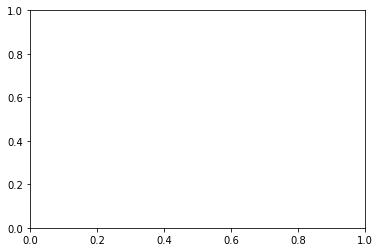

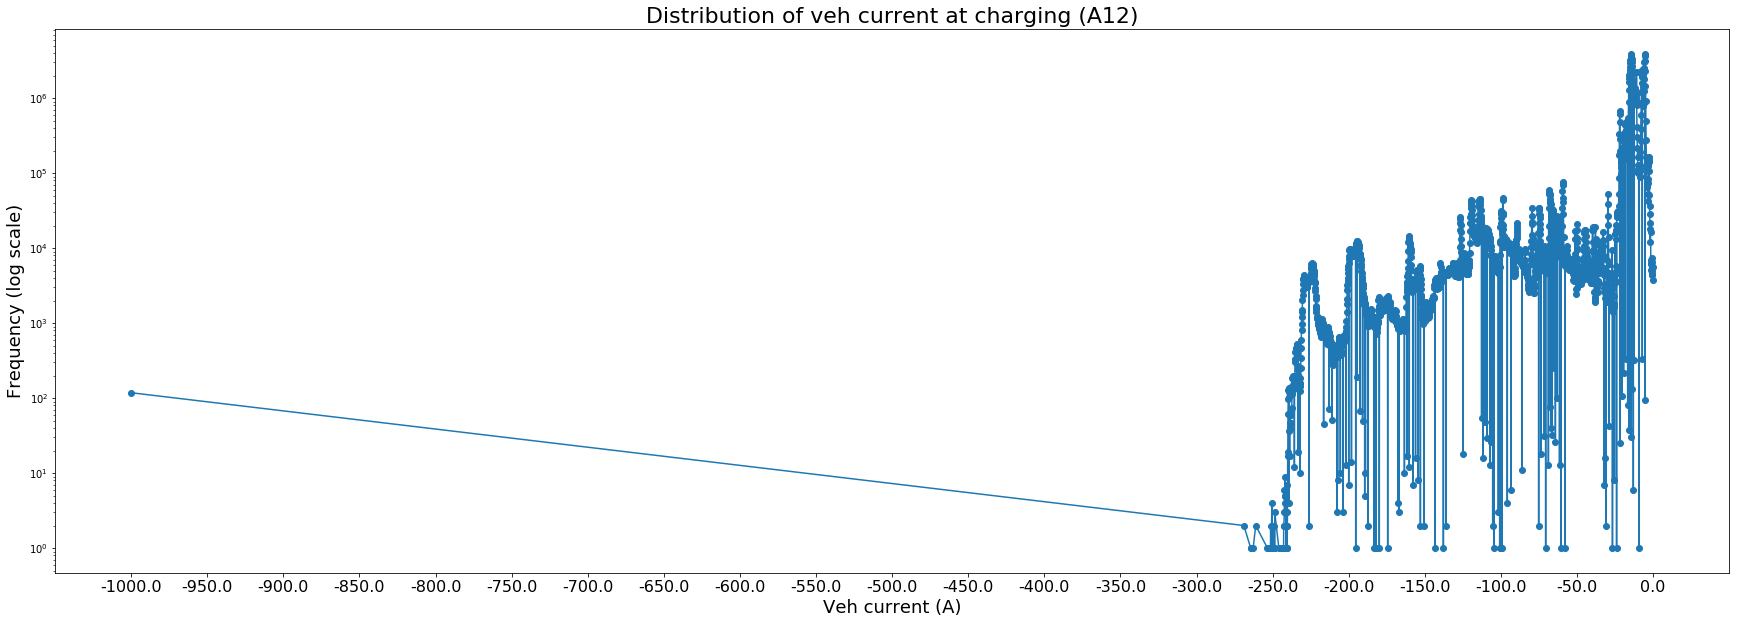

In [54]:
import numpy as np
import matplotlib.pyplot as plt

ax = plt.gca()
fig, ax = plt.subplots(1,1,sharex='col',figsize = [30, 10])

max_value = a12_pdf['veh_curr'].max()  # 0 for a26-t
min_value = a12_pdf['veh_curr'].min()   # -700 for a26-t
number_of_steps = 50
l = np.arange(min_value, max_value+1, number_of_steps)

ax.set(xticks=l, xticklabels=l)
ax.set_yscale('log')

ax.plot(a12_pdf['veh_curr'], a12_pdf['cnt'], '-o')

ax.set_title('Distribution of veh current at charging (A12)', fontsize=22)
ax.set_xlabel('Veh current (A)', fontsize=18)
ax.set_ylabel('Frequency (log scale)', fontsize=18)
ax.set_xticklabels(l, fontsize=16)  
#a26_pdf.plot.bar(figsize=(30, 10), x='veh_curr', y='cnt', ax=ax)

In [57]:
import plotly.graph_objects as go

fig = go.Figure(
    go.Scatter(
        x=a12_pdf['veh_curr'], y=a12_pdf['cnt'], name='Current', marker=dict(color='blue', opacity=0.2)
    ))
 
fig.update_layout(title='Distribution of veh current at charging (A12)',
                   xaxis_title='Veh current',
                   yaxis_title='Frequency')

fig.show()